In [1]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.constraints import maxnorm
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse, random, pickle, cv2, os, matplotlib
matplotlib.use("Agg")
%matplotlib inline

Using TensorFlow backend.


In [2]:
datagen = ImageDataGenerator()
data = []
labels = []

In [3]:
imagePaths = sorted(list(paths.list_images('./images')))
random.seed(42)
random.shuffle(imagePaths)

## Argumentation, Resize, Flatten and append to data,label lists
### Flattening: 64x64x3 = 12288

In [4]:
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64, 64))
    data.append(image)
    datagen.apply_transform(image,{'theta':20,'shear':20,'zx':0.2,'zy':0.2})
    datagen.apply_transform(image,{'flip_horizontal':True})
    datagen.apply_transform(image,{'zoom_rage':0.5})
    data.append(image)
    datagen.apply_transform(image,{'theta':25,'shear':25,'zx':0.2,'zy':0.2})
    datagen.apply_transform(image,{'flip_vertical':True})
    datagen.apply_transform(image,{'zoom_rage':0.5})
    data.append(image)
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    labels.append(label)
    labels.append(label)

In [5]:
len(data),len(labels)

(339, 339)

## Scale the raw pixel intensities to the range [0, 1] from [0, 255]

In [6]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

## Train, Test split of 75, 25

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

In [8]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [9]:
model = Sequential()

model.add(ZeroPadding2D((2,2),input_shape=(64,64,3)))

model.add(Convolution2D(64,(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((4,4), strides=(2,2)))
model.add(Convolution2D(128,(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Convolution2D(128,(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((4,4), strides=(2,2)))
model.add(Convolution2D(256,(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Convolution2D(256,(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((4,4), strides=(2,2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, input_shape=(4096,), activation="relu", kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(len(lb.classes_), activation="softmax", kernel_constraint=maxnorm(3)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 68, 68, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 68, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 68, 68, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 33, 33, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 33, 128)       0         
__________

In [10]:
BS = 32
INIT_LR = 0.0025
EPOCHS = 30
print("[INFO] training network...")
opt = SGD(lr=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] training network...


In [11]:
H = model.fit(trainX, trainY, validation_data=(testX, testY),epochs=EPOCHS, batch_size=BS)

Train on 254 samples, validate on 85 samples
Epoch 1/30
254/254 [==============================] - 13s 51ms/step - loss: 3.4320 - acc: 0.1772 - val_loss: 1.8608 - val_acc: 0.1647
Epoch 2/30
254/254 [==============================] - 12s 46ms/step - loss: 2.2670 - acc: 0.2717 - val_loss: 1.7715 - val_acc: 0.2706
Epoch 3/30
254/254 [==============================] - 12s 48ms/step - loss: 1.6945 - acc: 0.3268 - val_loss: 1.7755 - val_acc: 0.2000
Epoch 4/30
254/254 [==============================] - 12s 47ms/step - loss: 1.4671 - acc: 0.3976 - val_loss: 1.3621 - val_acc: 0.3647
Epoch 5/30
254/254 [==============================] - 12s 49ms/step - loss: 1.3821 - acc: 0.4291 - val_loss: 1.2950 - val_acc: 0.5059
Epoch 6/30
254/254 [==============================] - 14s 55ms/step - loss: 1.2697 - acc: 0.4685 - val_loss: 1.4120 - val_acc: 0.3882
Epoch 7/30
254/254 [==============================] - 13s 53ms/step - loss: 1.2110 - acc: 0.5039 - val_loss: 1.3507 - val_acc: 0.4353
Epoch 8/30
254/25

[INFO] evaluating network...
                     precision    recall  f1-score   support

       akshay_kumar       1.00      0.67      0.80        15
       katrina_kaif       0.74      1.00      0.85        14
nawazuddin_siddiqui       0.79      0.79      0.79        14
      ranbir_kapoor       1.00      1.00      1.00        20
        zarine_khan       1.00      1.00      1.00        22

          micro avg       0.91      0.91      0.91        85
          macro avg       0.90      0.89      0.89        85
       weighted avg       0.92      0.91      0.90        85



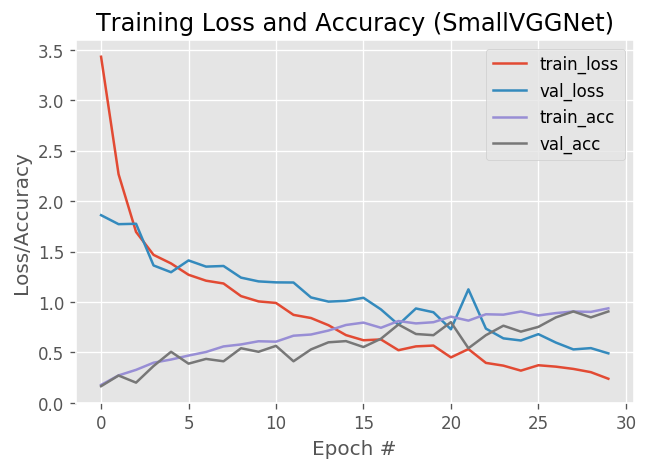

In [12]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(dpi=120)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy (SmallVGGNet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('stats.png')

## Total Accuracy of the Model

In [13]:
scores = model.evaluate(testX, testY, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 90.59%
